**Import and Clean Data**

In [3]:
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np


## comb data 
def open_ErYb_data(data_path, header=2):
    # keys to read out as string
    key2read = ["MJD", "timer", "SDR:frep_ErYb", "fo_ErYb", "fb_Si_ErYb", "fb_Al_ErYb", "fb_Yb_ErYb"] 
    types = {key: str for key in key2read}
    types["MJD"] = float
 
    # # Read the CSV file
    data = pd.read_csv(data_path, header=1, delimiter="\t", dtype=types, engine="python")
 
    # Convert the strings to Decimal for the given keys
    for k in key2read:
        data[k] = data[k].apply(Decimal)
 
    # reindex data
    data.index = range(len(data))
 
    return data[list(types.keys())]

## Al shift data 
def open_shiftfile_Al(datapath):
    data = pd.read_csv(datapath, header=30, delimiter="\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data

## Sr shift data 
def open_shiftfile_Sr(datapath):
    data = pd.read_csv(datapath, header=22, delimiter="\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data
 
 ## Yb shift data
def open_shiftfile_Yb(datapath):
    data = pd.read_csv(datapath, header=8, delimiter=r"\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data
 
 
 
################################################################################
#############  Functions to find optical frequencies with comb equation ########
################################################################################
 
# frequency for Al+ clock
def compute_nuAl_ErYb(data):
    data["nuAl"] = -Decimal("105e6") + Decimal("560444") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Al_ErYb"]
    data["nuAl"] = Decimal(4) * data["nuAl"]   

# frequency for Sr clock 
def compute_nuSr_ErYb(data):
    data["nuSi"] = -Decimal("105e6") + Decimal("388752") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - Decimal("100e6")
    data["nuSr"] = (Decimal("1716882") / Decimal("777577")) * (data["nuSi"] - Decimal("216e6"))

# freuency for Yb clock
def compute_nuYb_ErYb(data):
    data["nuYb"] = -Decimal("105e6") + Decimal("518237") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Yb_ErYb"]
    data["nuYb"] = Decimal(2) * data["nuYb"]

################################################################################
#############################  Load data #######################################
################################################################################
 
path = "/Users/smt3/Documents/GitHub/atomic-clock/st-interp/three_clocks/"

# load comb data
data_ErYb = open_ErYb_data(path + "20240813_Deglitched_ErYb_only1.dat")
 
# load Al shift data 
shift_data_Al = open_shiftfile_Al(path + "20240813_Al+_Freq_Shifts_ErYb.dat")

# load Sr shift data 
shift_data_Sr = open_shiftfile_Sr(path + "20240813_Sr_Freq_Shifts.dat")

# load Yb shift data
shift_data_Yb = open_shiftfile_Yb(path + "20240813_Yb_Freq_Shifts.txt")

################################################################################
###############  get optical frequencies #############################
################################################################################
 
compute_nuAl_ErYb(data_ErYb)
compute_nuSr_ErYb(data_ErYb)
compute_nuYb_ErYb(data_ErYb) 
 
################################################################################
#########################  Data Processing #####################################
################################################################################

## Extract only "IS_GOOD" data for analysis 
good_condition_al = shift_data_Al["IS_GOOD"] == 1
shift_data_Al_good = shift_data_Al[good_condition_al].reset_index(drop=True)
good_condition_sr = shift_data_Sr["IS_GOOD"] == 1
shift_data_Sr_good = shift_data_Sr[good_condition_sr].reset_index(drop=True)
good_condition_yb = shift_data_Yb["IS_GOOD"] == 1
shift_data_Yb_good = shift_data_Yb[good_condition_yb].reset_index(drop=True)

common_mjd = data_ErYb["MJD"].astype(float)
nuAl = data_ErYb["nuAl"].astype(float)
nuSr = data_ErYb["nuSr"].astype(float)
nuYb = data_ErYb['nuYb'].astype(float)

print("Missing Al comb nu: ", nuAl.isna().sum())
print("Missing Sr comb nu: ", nuSr.isna().sum())
print("Missing Yb comb nu: ", nuYb.isna().sum())


Missing Al comb nu:  29
Missing Sr comb nu:  27
Missing Yb comb nu:  1500


In [ ]:
is_na = nuYb.isna()
max_streak = current_streak = 0
for val in is_na:
    if val:
        current_streak += 1
        max_streak = max(max_streak, current_streak)
    else:
        current_streak = 0
print("Total NaNs:", is_na.sum())
print("Longest sequence of NaNs:", max_streak, '\n')
#Note: nuYb ends before nuAl and nuSr (though have matching MJD values)


Total NaNs: 1500
Longest sequence of NaNs: 1479 



In [7]:
len_comb = len(common_mjd) 
len_Al = len(shift_data_Al_good['shift'])        
len_Sr = len(shift_data_Sr_good['shift'])        
len_Yb = len(shift_data_Yb_good['shift'])

end_comb_inx = len_comb - 1 - max_streak #longest missing streak occurs at the end
print("nuAl, nuSr, and nuYb start and end MJD: [", common_mjd[0], ', ', common_mjd[end_comb_inx], ']')
print("Al good shift start  and end MJD: [", shift_data_Al_good['MJD'][0], ', ', shift_data_Al_good['MJD'][len_Al-1], ']')
print("Sr good shift start  and end MJD: [", shift_data_Sr_good['MJD'][0], ', ', shift_data_Sr_good['MJD'][len_Sr-1], ']')
print("Yb good shift start and end MJD: [", shift_data_Yb_good['MJD'][0], ', ', shift_data_Yb_good['MJD'][len_Yb-1], ']')

nuAl, nuSr, and nuYb start and end MJD: [ 60535.682346 ,  60535.893888 ]
Al good shift start  and end MJD: [ 60535.6818403 ,  60535.9108218 ]
Sr good shift start  and end MJD: [ 60535.705143550906 ,  60535.9791847021 ]
Yb good shift start and end MJD: [ 60535.68922818 ,  60535.89320398 ]


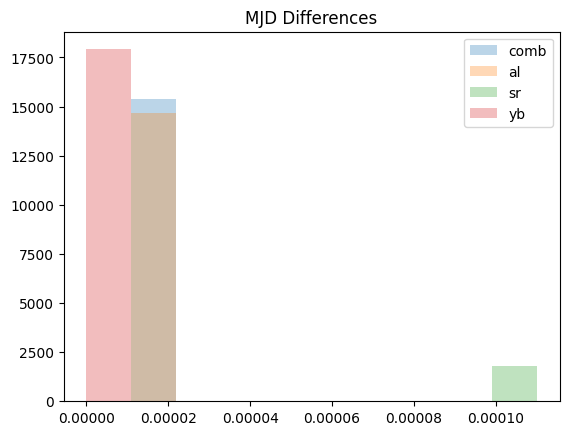

In [19]:
last_start_time = shift_data_Sr_good['MJD'][0]
first_end_time = shift_data_Yb_good['MJD'][len_Yb-1]

#function to extract element as close to target as possible w/out going over
def lb_extract(target, data):
    inx = 0
    stopper = 1
    while stopper == 1:
        if data[inx] <= target:
            inx += 1
        else:
            return inx  

#function to extract element as close to target as possible w/out going under 
def ub_extract(target, data):
    inx = 1
    stopper = 1
    while stopper == 1:
        if data[len(data)-inx] >= target:
            inx += 1
        else:
            return len(data)-inx  


comb = pd.DataFrame()
comb_start = ub_extract(target = last_start_time, data = common_mjd)  
comb_end = lb_extract(target = first_end_time, data = common_mjd)  
comb["MJD"] = common_mjd[comb_start:comb_end] 
comb["nuAl"] = nuAl[comb_start:comb_end]
comb['nuAl'] = pd.to_numeric(comb['nuAl'], errors='coerce')
comb["nuSr"] = nuSr[comb_start:comb_end]
comb['nuSr'] = pd.to_numeric(comb['nuSr'], errors='coerce')
comb["nuYb"] = nuYb[comb_start:comb_end]
comb['nuYb'] = pd.to_numeric(comb['nuYb'], errors='coerce')

al_start = ub_extract(target = last_start_time, data = shift_data_Al_good["MJD"])
al_end = lb_extract(target = first_end_time, data = shift_data_Al_good["MJD"])  
shift_data_Al = shift_data_Al_good[al_start:al_end]

sr_start = 0
sr_end = lb_extract(target = first_end_time, data = shift_data_Sr_good["MJD"])  
shift_data_Sr = shift_data_Sr_good[sr_start:sr_end]

yb_start = ub_extract(target = last_start_time, data = shift_data_Yb_good["MJD"])
yb_end = len_Yb-1
shift_data_Yb = shift_data_Yb_good[yb_start:yb_end]


comb = comb.reset_index(drop=True)  
shift_data_Al = shift_data_Al.reset_index(drop=True)
shift_data_Sr = shift_data_Sr.reset_index(drop=True)
shift_data_Yb = shift_data_Yb.reset_index(drop=True)

## Create data frame of differences in MDJ values for each series 
data = {
    "comb": comb.MJD.diff(),
    "al": shift_data_Al.MJD.diff(),
    "sr": shift_data_Sr.MJD.diff(),
    "yb": shift_data_Yb.MJD.diff()
} 
mjd_diff = pd.DataFrame(data)
#print(mjd_diff.head(5))

plt.hist(data['comb'], alpha=0.3, range =[0, 0.00011], 
          label='comb') 
plt.hist(data['al'], alpha=0.3, range =[0, 0.00011], 
          label='al') 
plt.hist(data['sr'], alpha=0.3, range =[0, 0.00011],
          label='sr') 
plt.hist(data['yb'], alpha=0.3, range =[0, 0.00011],
          label='yb') 
plt.legend(loc='upper right') 
plt.title('MJD Differences') 
plt.show()

**Method 1**: Align Clock 1 with the observations of the comb. Then align Clock 2 with the observations of the comb. Proceed to derive the ratio time series for analysis. The result of this approach will be a time series with the same irregularities in sampling as the comb series.  

Clock 1 is observed with either a similar or a lower frequency than Clock 2 and that Clock 2 is observed with a similar frequency as the comb sub-series: Sr = Clock 1; Al = Clock 2. 

**Method 2**: Realign the comb time series so that the observations are regularly sampled along the time interval of interest, i.e so that $(t_{OFC, i+1} - t_{OFC,i})$ are equal for all $i \in \{2, \dots, n_{OFC}\}$. Align Clock 1 with the new comb series. Align Clock 2 with the new comb series. Proceed to derive the ratio time series for analysis. The result of this approach will be a regularly sampled time series.  

**Method 3**: Align Clock 1 with the observations of Clock 2. Then align the comb with Clock 2. Proceed to derive the ratio time series for analysis. The result of this approach will be a target series with the same irregularities in sampling as in Clock 2. This approach essentially disregards (or masks) comb data for the sake of matching the observational time points of Clock 2. 

**Method 4**: Realign the time series from Clock 2 so that the observations are regularly sampled along the time interval of interest, i.e so that $(t_{C2, i+1} - t_{C2,i})$ are equal for all $i \in \{2, \dots, n_{C2}\}$. Align Clock 1 with the new series for Clock 2. Align the comb series with the new series for Clock 2. Proceed to derive the ratio time series for analysis. The result of this approach will be a regularly sampled time series. 
